# Example 2. Using WAC-Net

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/softmatterlab/Quantitative-Microplankton-Tracker/blob/main/examples/2-example_WAC-Net.ipynb)

This example demonstrates how to use a pre-trained WAC-Net (Weighted average convolutional neural network) on experimental images to extract more accurate values of dry mass

**NOTE**:
- If you're running this notebook on your local machine, please comment the code in the cell below

In [1]:
!git clone https://github.com/softmatterlab/Quantitative-Microplankton-Tracker.git
%cd Quantitative-Microplankton-Tracker/examples/

In [2]:
%matplotlib inline
import sys
sys.path.append("..")

## 1. Setup
Import the dependencies to run this tutorial. 

In [3]:
import glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import deeptrack as dt

## 2. Load experimental holographic image
Experimental images are located in ```sample-data``` folder

In [4]:
# Load figure 3 data (feeding events)
predator_sequence = np.load(
    "../data/data_figure3/predator_sequence.npy"
)

prey_sequence = np.load(
    "../data/data_figure3/prey_sequence.npy"
)

# Load figure 4 data (division events)
cell1_sequence = np.load(
    "../data/data_figure4/Cell1_sequence.npy"
)

cell2_sequence = np.load(
    "../data/data_figure4/Cell2_sequence.npy"
)

cell3_sequence = np.load(
    "../data/data_figure4/Cell3_sequence.npy"
)

### 2.1. Visualize prey and predator planktons

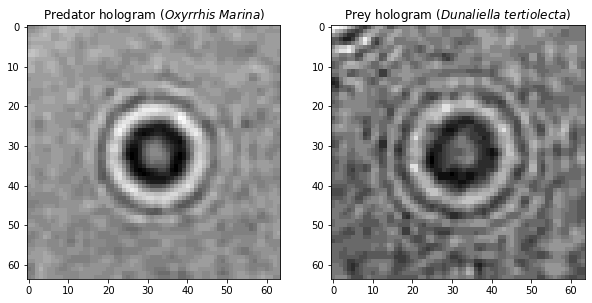

In [5]:
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.title("Predator hologram ($\it{Oxyrrhis\ Marina}$)")
plt.imshow(predator_sequence[0], cmap="gray")

plt.subplot(1,2,2)
plt.title("Prey hologram ($\it{Dunaliella\ tertiolecta}$)")
plt.imshow(prey_sequence[0], cmap="gray")

## 3. Load pre-trained WAC-Net model
We define the WAC-Net model and load the weights from a pre-trained model. 

In [6]:
# WAC-Net trained for feeding events

feeding_model = dt.models.WACNet(outputs = 2) # 2 outputs: dry mass and radius
feeding_model.load_weights(
    "../pre-trained-models/WACNet_dry_mass.h5"
)

# WAC-Net models trained for division events

division_event_models_loc = glob.glob(
    "../pre-trained-models/division-event-models/*.h5"
)

division_models = []
for model_loc in division_event_models_loc:
    empty_model = dt.models.WACNet(outputs = 1)
    empty_model.load_weights(model_loc)
    division_models.append(empty_model)

## 4. WAC-Net prediction on experimental sequences

### 4.1. Example 1 - Feeding events
Feeding events are recorded in two sequences:
- ```predator_sequence``` contains predator frames
- ```prey_sequence```contains prey frames

#### 4.1.1. Normalise the experimental image
Normalise and reshape the image for WAC-Net prediction

In [7]:
def Normalise(images, batch = 15):
    Normalised = []
    for i in range(len(images)):
        Normalised.append(images[i]/np.median(images[i]))
    Normalised = np.array(Normalised)-1
    proc = []
    
    #sliding window
    for i in range(len(Normalised)-batch+1):
        proc.append(Normalised[i:i+batch])
    return np.expand_dims(proc, axis = -1)

In [8]:
# Funtion to convert the predicted dry mass to real dry mass units (pico grams)
def real_dm(p, a=209.16, b=0.28, sp_ri_inc = 0.21):
    return (p*a+b)/sp_ri_inc

#### 4.1.2. Prediction on experimental sequences
Experimental sequences are normalized with ```batch``` size of 1. ```batch``` value can be increased to generate a sliding window of the experimental sequence. The WAC-Net assigns weights to the images with in sliding windows to predict the best possible value for dry mass considering all the frames.

In [9]:
prediction_predator = feeding_model.predict(
    Normalise(
        predator_sequence,
        batch = 1
    )
)

prediction_prey = feeding_model.predict(
    Normalise(
        prey_sequence,
        batch = 1
    )
)

#### 4.1.3. Convert values to real dry mass units

In [10]:
drymass_predator = real_dm(prediction_predator[:,0])
drymass_prey = real_dm(prediction_prey[:,0])

#### 4.4. Visualise the dry mass transition in a feeding event

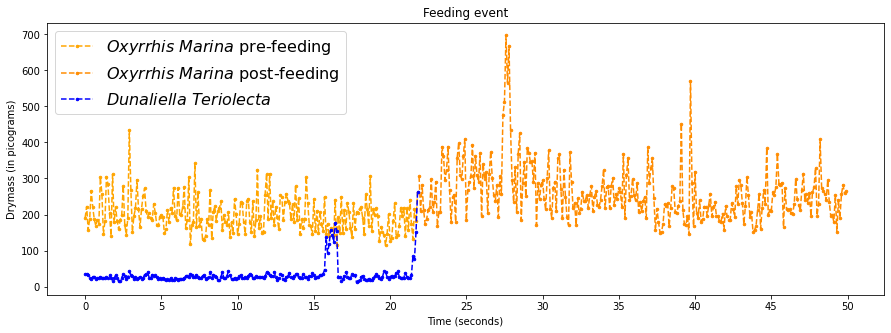

In [11]:
feeding_at = 219

fig, ax = plt.subplots(figsize=(15, 5))
plt.title("Feeding event")
plt.plot(np.arange(0,feeding_at,1), drymass_predator[0:feeding_at], linestyle='dashed',color='orange', marker='.', label='$\it{Oxyrrhis\ Marina}$ pre-feeding', alpha = 1, markersize = '5')
plt.plot(np.arange(feeding_at,len(drymass_predator), 1),drymass_predator[feeding_at:], linestyle='dashed',color='darkorange', marker='.', label='$\it{Oxyrrhis\ Marina}$ post-feeding', alpha = 1, markersize = '5')
plt.plot(drymass_prey[:feeding_at], linestyle='dashed',color='blue', marker='.', label='$\it{Dunaliella\ Teriolecta}$', alpha=1, markersize = '5')

plt.xlabel('Time (seconds)')
plt.ylabel('Drymass (in picograms)')

xticks = np.arange(0,550,50)
ax.set_xticks(xticks)
ax.set_xticklabels([int(x*(1/10)) for x in xticks])

plt.legend(prop={'size': 16})
plt.show()

### 4.2. Example 2 - Double division event
Division events are recorded in three sequences:
- ```cell1_sequence``` contains frames of parent cell, Gen 1 daughter cell 1, and Gen 2 daughter cell 1
- ```cell2_sequence``` contains frames of Gen 1 daughter cell 2 (along with parent cell)
- ```cell3_sequence``` contains frames of Gen 2 daughter cell 2 (along with parent cell and Gen 1 daugher cell 1)


#### 4.2.1. Normalise and predict
Function to de-normalise the dry mass values

In [12]:
def dm_range(rad_range, ri_range):
    m = lambda rad, ri: ((4*np.pi)/3) * ((rad*1e+6)**3) * (ri-1.33)
    return m(rad_range[0], ri_range[0]), m(rad_range[1], ri_range[1])
dm_vals = dm_range([4e-6, 9e-6], [1.35, 1.38])
dm_vals

(5.361651462126584, 152.6814029644634)

Predictions on cell 1 sequence

In [13]:
_dm_cell1=[]
for i in range(len(division_models)): 

    pred = division_models[i].predict(
        Normalise(
            cell1_sequence,
            batch = 15
        )
    )[:,0]
    
    pred = real_dm(pred, dm_vals[1]-dm_vals[0], dm_vals[0])
    _dm_cell1.append(pred)

dm_cell1 = np.mean(_dm_cell1, axis=0)

Predictions on cell 2 sequence

In [14]:
_dm_cell2=[]
for i in range(len(division_models)): 

    pred = division_models[i].predict(
        Normalise(
            cell2_sequence,
        )
    )[:,0]
    
    pred = real_dm(pred, dm_vals[1]-dm_vals[0], dm_vals[0])
    _dm_cell2.append(pred)

dm_cell2 = np.mean(_dm_cell2, axis=0)

Predictions on cell 3 sequence

In [15]:
_dm_cell3=[]
for i in range(len(division_models)): 

    pred = division_models[i].predict(
        Normalise(
            cell3_sequence,
        )
    )[:,0]
    
    pred = real_dm(pred, dm_vals[1]-dm_vals[0], dm_vals[0])
    _dm_cell3.append(pred)

dm_cell3 = np.mean(_dm_cell3, axis=0)

#### 4.2.2. Visualise the dry mass dynamics in a double division event

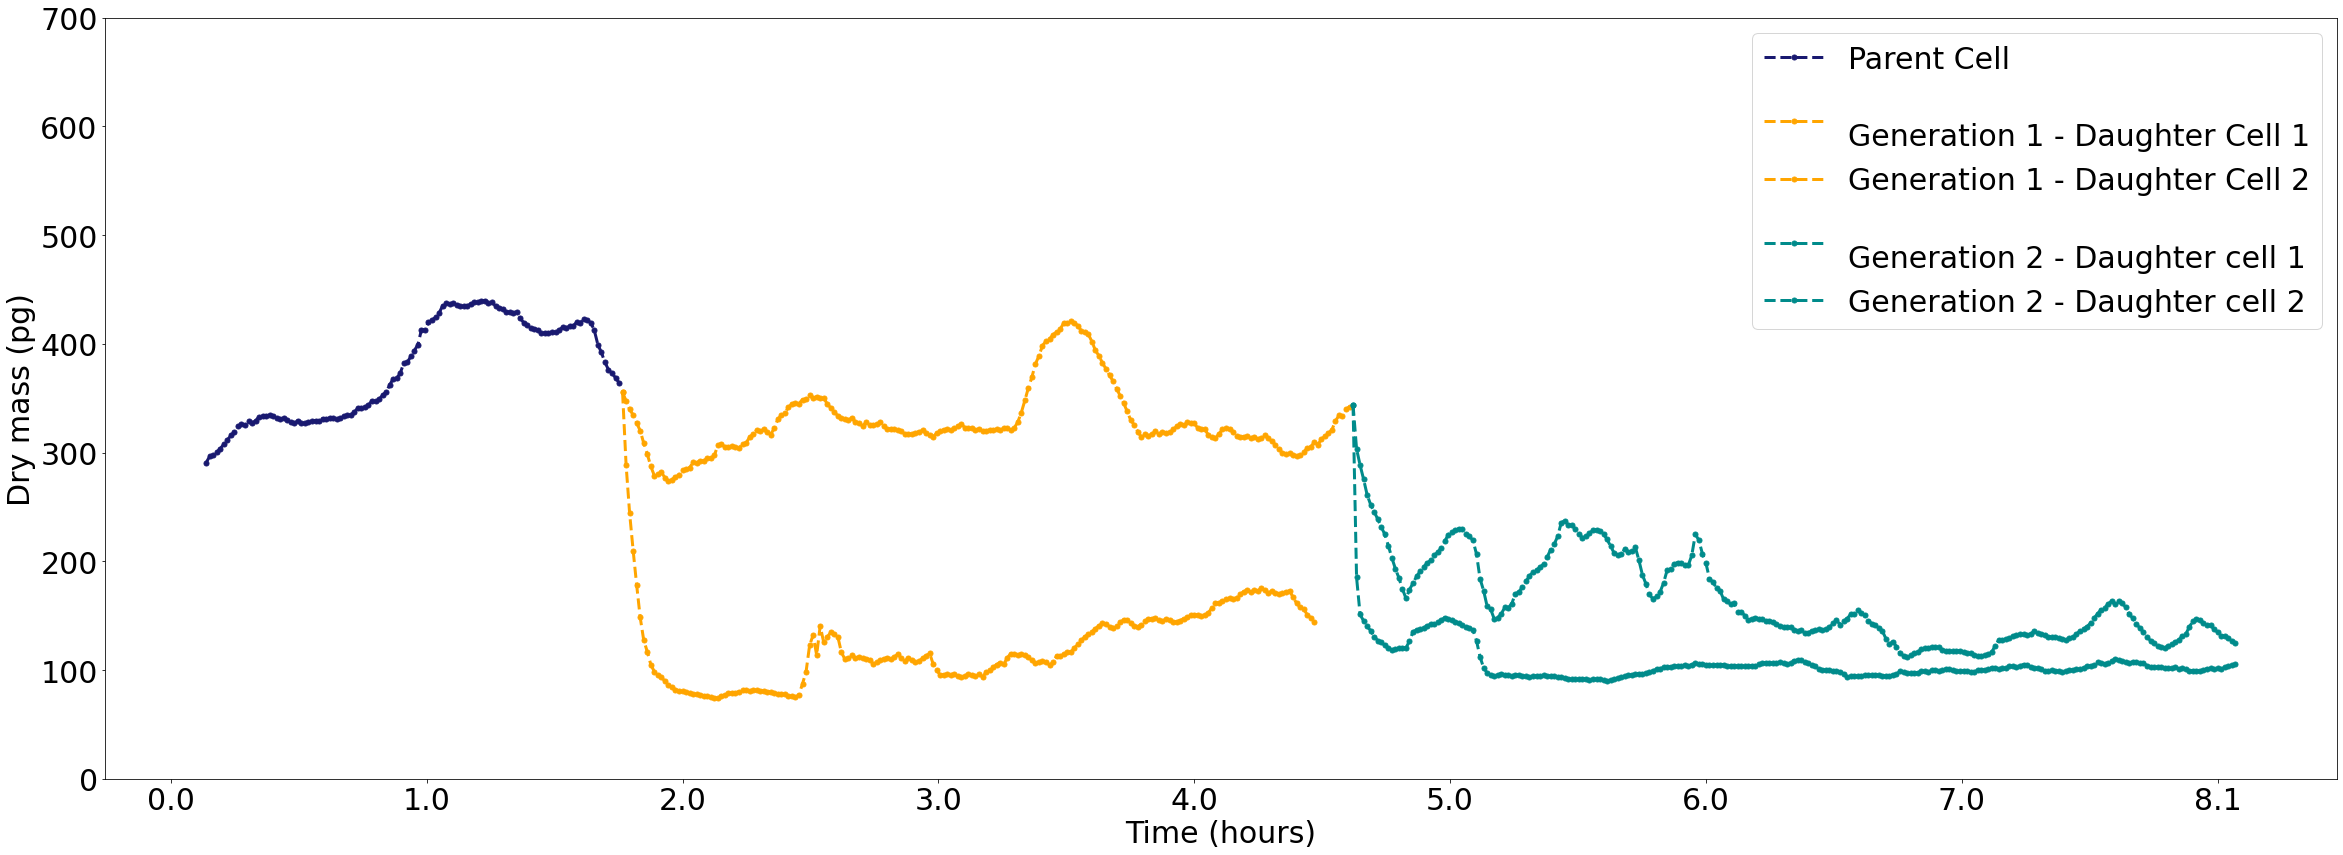

In [16]:
time = np.arange(0, len(dm_cell1), 1)

fig,ax = plt.subplots(figsize=(40, 14))


dt1 = 128
dt2 = 335
end1 = 600

daughter_lim = 10
plt.plot(time[10:dt1], dm_cell1[10:dt1], linestyle='dashed', color="midnightblue",
         marker='.', label='Parent Cell', alpha=1, markersize=10, linewidth=3)  # parentcell1

plt.plot(time[dt1:dt2], dm_cell1[dt1:dt2], linestyle='dashed', color="orange",
         marker='.', label='\nGeneration 1 - Daughter Cell 1', alpha=1, markersize='10', linewidth=3) #stationary cell

plt.plot(time[dt1:dt2-daughter_lim], dm_cell2[dt1:dt2-daughter_lim], linestyle='dashed', color="orange",
         marker='.', label='Generation 1 - Daughter Cell 2', alpha=1, markersize='10', linewidth=3)  #displaced cell


# Second generation----

plt.plot(time[dt2:end1], dm_cell1[dt2:end1], linestyle='dashed', color="darkcyan",
         marker='.', label='\nGeneration 2 - Daughter cell 1', alpha=1, markersize='10', linewidth=3)  # stationary cell

plt.plot(time[dt2:end1], dm_cell3[dt2:end1], linestyle='dashed', color="darkcyan",
         marker='.', label='Generation 2 - Daughter cell 2', alpha=1, markersize='10', linewidth=3)  # daughtercell1


def place_ticks(x = 10, y = 10):
    plt.locator_params(axis="x", nbins=x)
    plt.locator_params(axis="y", nbins=y)

xticks = np.arange(0,700,14.5)
ax.set_xticks(xticks)
ax.set_xticklabels([np.round(x*(5/6/60),1) for x in xticks])
place_ticks(x=10, y=10)

fs = 30
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.legend(prop={'size': fs})
plt.ylabel("Dry mass (pg)", fontsize=fs)
plt.xlabel("Time (hours)", fontsize=fs)

plt.ylim([0, 700])
plt.show()